# Conditional densities and affine transformations

In this chapter we will learn how `GaussianConditional` can be used in the `GT`. Imagine we have a set of random variables, where the marginal is given by $p(X)={\cal N}(\mu_X,\Sigma_X)$.

In [1]:
from objax import random
from jax import numpy as jnp
from matplotlib import pyplot as plt

from gaussian_toolbox.gaussian_algebra import densities

Dx = 1
mu_X = random.normal((1,1))
Sigma_X = jnp.array([[[1,]]])

p_X = densities.GaussianDensity(Sigma=Sigma_X, mu=mu_X)

Now we have a second set of variabels $Y$, for which we only know the conditional $p(Y\vert X)={\cal N}(\mu_{Y\vert X},\Sigma_{Y\vert X})$, where

$$
 \mu_{Y\vert X} = MX + b.
$$

Let's create such an object in `GT`.

In [2]:
from gaussian_toolbox.gaussian_algebra import conditionals

Dy = 1
M = random.normal((1, Dy, Dx))
b = random.normal((1, Dy))
Sigma_YcX = Sigma_X = jnp.array([[[.2,]]])

p_Y_given_X = conditionals.ConditionalGaussianDensity(M=M, b=b, Sigma=Sigma_YcX)
print(p_Y_given_X)

Conditional Gaussian density p(y|x)


In such a setup one is often interested in the following _affine_ operations

+ Joint transformation: $T_{\rm joint}[p(Y|X),p(X)] = p(X,Y)$
+ Marginal transformation: $T_{\rm marg}[p(Y|X),p(X)] = p(Y)$
+ Conditional transformation: $T_{\rm cond}[p(Y|X),p(X)] = p(X\vert Y)$

When $p(X)$ and $p(Y\vert X)$ have the form as described above `GT` enables us to quickly perform the operations. E.g. let's do the joint operation.

In [3]:
p_XY = p_Y_given_X.affine_joint_transformation(p_X)

This transformation gives back a `GaussianDensity` object, which we have encountered in the first part of the tutorial. Hence, we can solve integrals, evaluate it at different points, and sample it. Same holds for the marginal transform:

In [4]:
p_Y = p_Y_given_X.affine_marginal_transformation(p_X)

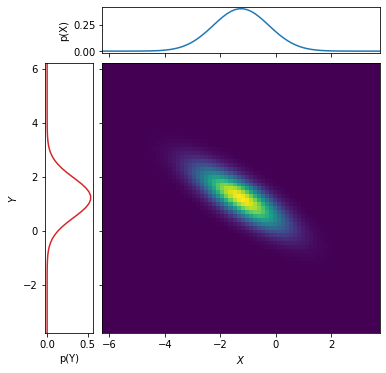

In [5]:
from gaussian_toolbox.gaussian_algebra import factors

# Create plot grid
reso = 70
xrange = (jnp.linspace(-5,5,reso) + p_X.mu).T
yrange = (jnp.linspace(-5,5,reso) + p_Y.mu).T
xmesh, ymesh = jnp.meshgrid(xrange[:,0], yrange[:,0])
xy = jnp.vstack([xmesh.flatten(), ymesh.flatten()]).T

from matplotlib import gridspec
fig = plt.figure(figsize=(6,6))
grid = gridspec.GridSpec(6,6,fig)
ax1 = fig.add_subplot(grid[1:,:1])
ax1.plot(p_Y(yrange).T, yrange[:,0], 'C3')
ax1.set_ylim(yrange[jnp.array([0,-1]),0])
ax1.set_ylabel('$Y$')
ax1.set_xlabel('p(Y)')
ax2 = fig.add_subplot(grid[:1,1:])
ax2.plot(xrange,p_X(xrange).T)
ax2.set_xlim(xrange[jnp.array([0,-1]), 0])
ax2.set_ylabel('p(X)')
ax2.set_xticklabels([])
ax3 = fig.add_subplot(grid[1:,1:])
ax3.pcolor(xrange[:,0], yrange[:,0], p_XY(xy).reshape((reso,reso)), shading='nearest')
ax3.set_xlabel('$X$')
ax3.set_xlim(xrange[jnp.array([0,-1]),0])
ax3.set_ylim(yrange[jnp.array([0,-1]),0])
ax3.set_yticklabels([])
plt.show()

The conditional transformation is a bit different, in the sense, that it does not return a `GaussianDensity`, but again a `ConditionalDensity`. To check consistency let's check, whether

$$
 T_{\rm marg}[T_{\rm cond}[p(Y|X),p(X)], p(Y)] = p(X)
$$

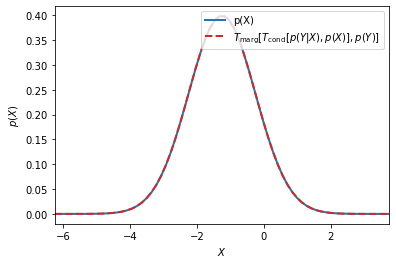

In [6]:
p_X_given_Y = p_Y_given_X.affine_conditional_transformation(p_X)
p_X2 = p_X_given_Y.affine_marginal_transformation(p_Y)
plt.plot(xrange[:,0], p_X(xrange).T, label='p(X)', lw=2)
plt.plot(xrange[:,0], p_X2(xrange).T, 'C3--', label=r'$T_{\rm marg}[T_{\rm cond}[p(Y|X),p(X)], p(Y)] $', lw=2)
plt.legend(loc=1)
plt.xlim(xrange[jnp.array([0,-1]),0])
plt.xlabel('$X$')
plt.ylabel('$p(X)$')
plt.show()

As we see, the transformation is consistent.

Sometimes, we also which to condition on some specific value, i.e. $p(Y\vert X=x)$ which transforms the `ConditionalGaussianDensity` again in a `GaussianPDF`. Let's condition $p(X\vert Y=4)$.

In [7]:
p_Y_given_4 = p_Y_given_X(jnp.array([[4]]))

And again, we can see by visual inspection, that it makes sense

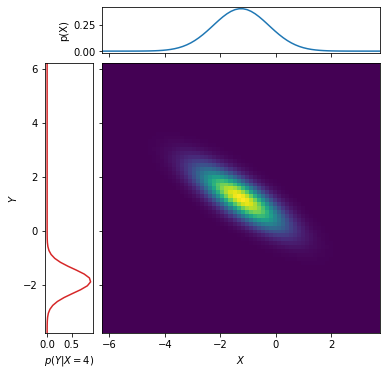

In [8]:
from gaussian_toolbox.gaussian_algebra import factors

from matplotlib import gridspec
fig = plt.figure(figsize=(6,6))
grid = gridspec.GridSpec(6,6,fig)
ax1 = fig.add_subplot(grid[1:,:1])
ax1.plot(p_Y_given_4(yrange).T, yrange[:,0], 'C3')
ax1.set_ylim(yrange[jnp.array([0,-1]),0])
ax1.set_ylabel('$Y$')
ax1.set_xlabel(r'$p(Y\vert X=4)$')
ax2 = fig.add_subplot(grid[:1,1:])
ax2.plot(xrange,p_X(xrange).T)
ax2.set_xlim(xrange[jnp.array([0,-1]), 0])
ax2.set_ylabel('p(X)')
ax2.set_xticklabels([])
ax3 = fig.add_subplot(grid[1:,1:])
ax3.pcolor(xrange[:,0], yrange[:,0], p_XY(xy).reshape((reso,reso)), shading='nearest')
ax3.set_xlabel('$X$')
ax3.vlines(4,yrange[0],yrange[-1], color='C3')
ax3.set_xlim(xrange[jnp.array([0,-1]),0])
ax3.set_ylim(yrange[jnp.array([0,-1]),0])
ax3.set_yticklabels([])
plt.show()

__Why are affine transformations so useful?__ Let's consider Bayes' rule

$$
 p(W\vert {\cal D}) = \frac{p({\cal D}\vert W)p(W)}{p({\cal D})}.
$$

where ${\cal D}$ is data and $W$ parameters.

You start with _likelihood_ $p({\cal D}\vert W)$ (`GaussianConditionalDensity`) and _prior_ $p(W)$ (`GaussianPDF`). The affine transformations, give us the objects of interest in Bayesian inference.
+ Joint transformation $p({\cal D}, W) = T_{\rm joint}[p({\cal D}|W),p(W)]$ to get _joint likelihood_.
+ Marginal transformation $p({\cal D}) = T_{\rm marg}[p({\cal D}|W),p(W)]$ to get _marginal likelihood_.
+ Conditional transformation $p(W\vert {\cal D}) = T_{\rm cond}[p({\cal D}|W),p(W)]$ to get _posterior_.

In the next chapter, we will see as an example how easy linear regression is done.